In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "CIFAR10"
ood = "5:6:7:8:9"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data(shuffle_training_data=False)
config.print_labels()
dm = config.datamodule

assert dm

Files already downloaded and verified


  0%|                                                                                                                                                       | 0/50000 [00:00<?, ?it/s]

  9%|████████████                                                                                                                             | 4385/50000 [00:00<00:01, 43843.35it/s]

 18%|████████████████████████                                                                                                                 | 8792/50000 [00:00<00:00, 43974.66it/s]

 26%|███████████████████████████████████▉                                                                                                    | 13200/50000 [00:00<00:00, 44018.17it/s]

 35%|███████████████████████████████████████████████▉                                                                                        | 17618/50000 [00:00<00:00, 44081.53it/s]

 44%|███████████████████████████████████████████████████████████▉                                                                            | 22039/50000 [00:00<00:00, 44124.04it/s]

 53%|███████████████████████████████████████████████████████████████████████▉                                                                | 26462/50000 [00:00<00:00, 44158.79it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████                                                    | 30889/50000 [00:00<00:00, 44192.44it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████                                        | 35309/50000 [00:00<00:00, 44185.53it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 39744/50000 [00:00<00:00, 44236.32it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 44168/50000 [00:01<00:00, 44210.04it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 48596/50000 [00:01<00:00, 44229.75it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 44148.57it/s]

Files already downloaded and verified


  0%|                                                                                                                                                       | 0/10000 [00:00<?, ?it/s]

 44%|████████████████████████████████████████████████████████████▎                                                                            | 4400/10000 [00:00<00:00, 43998.05it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 8806/10000 [00:00<00:00, 44029.82it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 43949.60it/s]

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

5:6:7:8:9 za51lfb3


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    rnd_inp = []
    rnd_e_u = []
    rnd_e_v = []
    rnd_rcn = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_e_u.extend(e_u.detach().cpu().numpy())
        rnd_e_v.extend(e_v.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                         | 0/157 [00:00<?, ?it/s]

  1%|▉                                                                                                                                                | 1/157 [00:01<04:25,  1.70s/it]

  1%|█▊                                                                                                                                               | 2/157 [00:01<02:00,  1.29it/s]

  2%|██▊                                                                                                                                              | 3/157 [00:01<01:13,  2.09it/s]

  3%|███▋                                                                                                                                             | 4/157 [00:02<00:52,  2.94it/s]

  3%|████▌                                                                                                                                            | 5/157 [00:02<00:40,  3.79it/s]

  4%|█████▌                                                                                                                                           | 6/157 [00:02<00:32,  4.60it/s]

  4%|██████▍                                                                                                                                          | 7/157 [00:02<00:28,  5.32it/s]

  5%|███████▍                                                                                                                                         | 8/157 [00:02<00:25,  5.92it/s]

  6%|████████▎                                                                                                                                        | 9/157 [00:02<00:23,  6.41it/s]

  6%|█████████▏                                                                                                                                      | 10/157 [00:02<00:21,  6.79it/s]

  7%|██████████                                                                                                                                      | 11/157 [00:02<00:20,  7.08it/s]

  8%|███████████                                                                                                                                     | 12/157 [00:03<00:19,  7.29it/s]

  8%|███████████▉                                                                                                                                    | 13/157 [00:03<00:19,  7.45it/s]

  9%|████████████▊                                                                                                                                   | 14/157 [00:03<00:18,  7.56it/s]

 10%|█████████████▊                                                                                                                                  | 15/157 [00:03<00:18,  7.64it/s]

 10%|██████████████▋                                                                                                                                 | 16/157 [00:03<00:18,  7.70it/s]

 11%|███████████████▌                                                                                                                                | 17/157 [00:03<00:18,  7.74it/s]

 11%|████████████████▌                                                                                                                               | 18/157 [00:03<00:17,  7.77it/s]

 12%|█████████████████▍                                                                                                                              | 19/157 [00:03<00:17,  7.79it/s]

 13%|██████████████████▎                                                                                                                             | 20/157 [00:04<00:17,  7.80it/s]

 13%|███████████████████▎                                                                                                                            | 21/157 [00:04<00:17,  7.81it/s]

 14%|████████████████████▏                                                                                                                           | 22/157 [00:04<00:17,  7.82it/s]

 15%|█████████████████████                                                                                                                           | 23/157 [00:04<00:17,  7.83it/s]

 15%|██████████████████████                                                                                                                          | 24/157 [00:04<00:16,  7.83it/s]

 16%|██████████████████████▉                                                                                                                         | 25/157 [00:04<00:16,  7.82it/s]

 17%|███████████████████████▊                                                                                                                        | 26/157 [00:04<00:16,  7.82it/s]

 17%|████████████████████████▊                                                                                                                       | 27/157 [00:05<00:16,  7.83it/s]

 18%|█████████████████████████▋                                                                                                                      | 28/157 [00:05<00:16,  7.83it/s]

 18%|██████████████████████████▌                                                                                                                     | 29/157 [00:05<00:16,  7.83it/s]

 19%|███████████████████████████▌                                                                                                                    | 30/157 [00:05<00:16,  7.83it/s]

 20%|████████████████████████████▍                                                                                                                   | 31/157 [00:05<00:16,  7.84it/s]

 20%|█████████████████████████████▎                                                                                                                  | 32/157 [00:05<00:15,  7.84it/s]

 21%|██████████████████████████████▎                                                                                                                 | 33/157 [00:05<00:15,  7.84it/s]

 22%|███████████████████████████████▏                                                                                                                | 34/157 [00:05<00:15,  7.84it/s]

 22%|████████████████████████████████                                                                                                                | 35/157 [00:06<00:15,  7.84it/s]

 23%|█████████████████████████████████                                                                                                               | 36/157 [00:06<00:15,  7.84it/s]

 24%|█████████████████████████████████▉                                                                                                              | 37/157 [00:06<00:15,  7.83it/s]

 24%|██████████████████████████████████▊                                                                                                             | 38/157 [00:06<00:15,  7.83it/s]

 25%|███████████████████████████████████▊                                                                                                            | 39/157 [00:06<00:15,  7.82it/s]

 25%|████████████████████████████████████▋                                                                                                           | 40/157 [00:06<00:14,  7.83it/s]

 26%|█████████████████████████████████████▌                                                                                                          | 41/157 [00:06<00:14,  7.83it/s]

 27%|██████████████████████████████████████▌                                                                                                         | 42/157 [00:06<00:14,  7.83it/s]

 27%|███████████████████████████████████████▍                                                                                                        | 43/157 [00:07<00:14,  7.83it/s]

 28%|████████████████████████████████████████▎                                                                                                       | 44/157 [00:07<00:14,  7.83it/s]

 29%|█████████████████████████████████████████▎                                                                                                      | 45/157 [00:07<00:14,  7.83it/s]

 29%|██████████████████████████████████████████▏                                                                                                     | 46/157 [00:07<00:14,  7.83it/s]

 30%|███████████████████████████████████████████                                                                                                     | 47/157 [00:07<00:14,  7.84it/s]

 31%|████████████████████████████████████████████                                                                                                    | 48/157 [00:07<00:13,  7.83it/s]

 31%|████████████████████████████████████████████▉                                                                                                   | 49/157 [00:07<00:13,  7.83it/s]

 32%|█████████████████████████████████████████████▊                                                                                                  | 50/157 [00:07<00:13,  7.83it/s]

 32%|██████████████████████████████████████████████▊                                                                                                 | 51/157 [00:08<00:13,  7.83it/s]

 33%|███████████████████████████████████████████████▋                                                                                                | 52/157 [00:08<00:13,  7.84it/s]

 34%|████████████████████████████████████████████████▌                                                                                               | 53/157 [00:08<00:13,  7.84it/s]

 34%|█████████████████████████████████████████████████▌                                                                                              | 54/157 [00:08<00:13,  7.83it/s]

 35%|██████████████████████████████████████████████████▍                                                                                             | 55/157 [00:08<00:13,  7.84it/s]

 36%|███████████████████████████████████████████████████▎                                                                                            | 56/157 [00:08<00:12,  7.83it/s]

 36%|████████████████████████████████████████████████████▎                                                                                           | 57/157 [00:08<00:12,  7.83it/s]

 37%|█████████████████████████████████████████████████████▏                                                                                          | 58/157 [00:08<00:12,  7.83it/s]

 38%|██████████████████████████████████████████████████████                                                                                          | 59/157 [00:09<00:12,  7.83it/s]

 38%|███████████████████████████████████████████████████████                                                                                         | 60/157 [00:09<00:12,  7.84it/s]

 39%|███████████████████████████████████████████████████████▉                                                                                        | 61/157 [00:09<00:12,  7.84it/s]

 39%|████████████████████████████████████████████████████████▊                                                                                       | 62/157 [00:09<00:12,  7.84it/s]

 40%|█████████████████████████████████████████████████████████▊                                                                                      | 63/157 [00:09<00:11,  7.84it/s]

 41%|██████████████████████████████████████████████████████████▋                                                                                     | 64/157 [00:09<00:11,  7.83it/s]

 41%|███████████████████████████████████████████████████████████▌                                                                                    | 65/157 [00:09<00:11,  7.83it/s]

 42%|████████████████████████████████████████████████████████████▌                                                                                   | 66/157 [00:09<00:11,  7.83it/s]

 43%|█████████████████████████████████████████████████████████████▍                                                                                  | 67/157 [00:10<00:11,  7.83it/s]

 43%|██████████████████████████████████████████████████████████████▎                                                                                 | 68/157 [00:10<00:11,  7.84it/s]

 44%|███████████████████████████████████████████████████████████████▎                                                                                | 69/157 [00:10<00:11,  7.84it/s]

 45%|████████████████████████████████████████████████████████████████▏                                                                               | 70/157 [00:10<00:11,  7.83it/s]

 45%|█████████████████████████████████████████████████████████████████                                                                               | 71/157 [00:10<00:10,  7.82it/s]

 46%|██████████████████████████████████████████████████████████████████                                                                              | 72/157 [00:10<00:10,  7.82it/s]

 46%|██████████████████████████████████████████████████████████████████▉                                                                             | 73/157 [00:10<00:10,  7.82it/s]

 47%|███████████████████████████████████████████████████████████████████▊                                                                            | 74/157 [00:11<00:10,  7.82it/s]

 48%|████████████████████████████████████████████████████████████████████▊                                                                           | 75/157 [00:11<00:10,  7.83it/s]

 48%|█████████████████████████████████████████████████████████████████████▋                                                                          | 76/157 [00:11<00:10,  7.83it/s]

 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 77/157 [00:11<00:10,  7.83it/s]

 50%|███████████████████████████████████████████████████████████████████████▌                                                                        | 78/157 [00:11<00:10,  7.84it/s]

 50%|████████████████████████████████████████████████████████████████████████▍                                                                       | 79/157 [00:11<00:09,  7.83it/s]

 51%|█████████████████████████████████████████████████████████████████████████▍                                                                      | 80/157 [00:11<00:09,  7.84it/s]

 52%|██████████████████████████████████████████████████████████████████████████▎                                                                     | 81/157 [00:11<00:09,  7.84it/s]

 52%|███████████████████████████████████████████████████████████████████████████▏                                                                    | 82/157 [00:12<00:09,  7.84it/s]

 53%|████████████████████████████████████████████████████████████████████████████▏                                                                   | 83/157 [00:12<00:09,  7.84it/s]

 54%|█████████████████████████████████████████████████████████████████████████████                                                                   | 84/157 [00:12<00:09,  7.84it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▉                                                                  | 85/157 [00:12<00:09,  7.84it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▉                                                                 | 86/157 [00:12<00:09,  7.83it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▊                                                                | 87/157 [00:12<00:08,  7.83it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▋                                                               | 88/157 [00:12<00:08,  7.82it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▋                                                              | 89/157 [00:12<00:08,  7.82it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▌                                                             | 90/157 [00:13<00:08,  7.83it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▍                                                            | 91/157 [00:13<00:08,  7.83it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▍                                                           | 92/157 [00:13<00:08,  7.83it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▎                                                          | 93/157 [00:13<00:08,  7.83it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▏                                                         | 94/157 [00:13<00:08,  7.83it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▏                                                        | 95/157 [00:13<00:07,  7.84it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████                                                        | 96/157 [00:13<00:07,  7.84it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 97/157 [00:13<00:07,  7.83it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 98/157 [00:14<00:07,  7.83it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 99/157 [00:14<00:07,  7.83it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████                                                    | 100/157 [00:14<00:07,  7.83it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 101/157 [00:14<00:07,  7.84it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 102/157 [00:14<00:07,  7.84it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 103/157 [00:14<00:06,  7.83it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 104/157 [00:14<00:06,  7.84it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 105/157 [00:14<00:06,  7.84it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 106/157 [00:15<00:06,  7.83it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 107/157 [00:15<00:06,  7.83it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 108/157 [00:15<00:06,  7.83it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 109/157 [00:15<00:06,  7.83it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 110/157 [00:15<00:05,  7.83it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 111/157 [00:15<00:05,  7.83it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 112/157 [00:15<00:05,  7.83it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 113/157 [00:16<00:05,  7.83it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 114/157 [00:16<00:05,  7.83it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 115/157 [00:16<00:05,  7.84it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 116/157 [00:16<00:05,  7.83it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 117/157 [00:16<00:05,  7.83it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 118/157 [00:16<00:04,  7.84it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 119/157 [00:16<00:04,  7.83it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 120/157 [00:16<00:04,  7.83it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 121/157 [00:17<00:04,  7.83it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 122/157 [00:17<00:04,  7.83it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 123/157 [00:17<00:04,  7.83it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 124/157 [00:17<00:04,  7.83it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 125/157 [00:17<00:04,  7.83it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 126/157 [00:17<00:03,  7.83it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 127/157 [00:17<00:03,  7.84it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 128/157 [00:17<00:03,  7.84it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 129/157 [00:18<00:03,  7.83it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 130/157 [00:18<00:03,  7.83it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 131/157 [00:18<00:03,  7.83it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 132/157 [00:18<00:03,  7.83it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 133/157 [00:18<00:03,  7.84it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 134/157 [00:18<00:02,  7.83it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 135/157 [00:18<00:02,  7.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 136/157 [00:18<00:02,  7.83it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 137/157 [00:19<00:02,  7.83it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 138/157 [00:19<00:02,  7.84it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 139/157 [00:19<00:02,  7.84it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 140/157 [00:19<00:02,  7.84it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 141/157 [00:19<00:02,  7.84it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 142/157 [00:19<00:01,  7.84it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 143/157 [00:19<00:01,  7.84it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 144/157 [00:19<00:01,  7.84it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 145/157 [00:20<00:01,  7.84it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 146/157 [00:20<00:01,  7.84it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 147/157 [00:20<00:01,  7.83it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 148/157 [00:20<00:01,  7.84it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 149/157 [00:20<00:01,  7.84it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 150/157 [00:20<00:00,  7.84it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 151/157 [00:20<00:00,  7.83it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 152/157 [00:20<00:00,  7.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 153/157 [00:21<00:00,  7.83it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 154/157 [00:21<00:00,  7.83it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 155/157 [00:21<00:00,  7.83it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 156/157 [00:21<00:00,  7.84it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:21<00:00,  7.28it/s]

train - OK


  0%|                                                                                                                                                          | 0/40 [00:00<?, ?it/s]

  2%|███▋                                                                                                                                              | 1/40 [00:00<00:08,  4.64it/s]

  5%|███████▎                                                                                                                                          | 2/40 [00:00<00:06,  6.09it/s]

  8%|██████████▉                                                                                                                                       | 3/40 [00:00<00:05,  6.78it/s]

 10%|██████████████▌                                                                                                                                   | 4/40 [00:00<00:05,  7.17it/s]

 12%|██████████████████▎                                                                                                                               | 5/40 [00:00<00:04,  7.40it/s]

 15%|█████████████████████▉                                                                                                                            | 6/40 [00:00<00:04,  7.54it/s]

 18%|█████████████████████████▌                                                                                                                        | 7/40 [00:00<00:04,  7.63it/s]

 20%|█████████████████████████████▏                                                                                                                    | 8/40 [00:01<00:04,  7.69it/s]

 22%|████████████████████████████████▊                                                                                                                 | 9/40 [00:01<00:04,  7.73it/s]

 25%|████████████████████████████████████▎                                                                                                            | 10/40 [00:01<00:03,  7.76it/s]

 28%|███████████████████████████████████████▉                                                                                                         | 11/40 [00:01<00:03,  7.78it/s]

 30%|███████████████████████████████████████████▌                                                                                                     | 12/40 [00:01<00:03,  7.79it/s]

 32%|███████████████████████████████████████████████▏                                                                                                 | 13/40 [00:01<00:03,  7.81it/s]

 35%|██████████████████████████████████████████████████▊                                                                                              | 14/40 [00:01<00:03,  7.81it/s]

 38%|██████████████████████████████████████████████████████▍                                                                                          | 15/40 [00:02<00:03,  7.81it/s]

 40%|██████████████████████████████████████████████████████████                                                                                       | 16/40 [00:02<00:03,  7.82it/s]

 42%|█████████████████████████████████████████████████████████████▋                                                                                   | 17/40 [00:02<00:02,  7.82it/s]

 45%|█████████████████████████████████████████████████████████████████▎                                                                               | 18/40 [00:02<00:02,  7.83it/s]

 48%|████████████████████████████████████████████████████████████████████▉                                                                            | 19/40 [00:02<00:02,  7.83it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 20/40 [00:02<00:02,  7.83it/s]

 52%|████████████████████████████████████████████████████████████████████████████▏                                                                    | 21/40 [00:02<00:02,  7.83it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▊                                                                 | 22/40 [00:02<00:02,  7.83it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▍                                                             | 23/40 [00:03<00:02,  7.83it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 24/40 [00:03<00:02,  7.82it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 25/40 [00:03<00:01,  7.83it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 26/40 [00:03<00:01,  7.83it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 27/40 [00:03<00:01,  7.83it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 28/40 [00:03<00:01,  7.83it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 29/40 [00:03<00:01,  7.83it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 30/40 [00:03<00:01,  7.82it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 31/40 [00:04<00:01,  7.83it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 32/40 [00:04<00:01,  7.83it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 33/40 [00:04<00:00,  7.83it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 34/40 [00:04<00:00,  7.83it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 35/40 [00:04<00:00,  7.83it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 36/40 [00:04<00:00,  7.83it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 37/40 [00:04<00:00,  7.83it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 38/40 [00:04<00:00,  7.84it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 39/40 [00:05<00:00,  7.84it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.76it/s]

val - OK


  0%|                                                                                                                                                          | 0/40 [00:00<?, ?it/s]

  2%|███▋                                                                                                                                              | 1/40 [00:00<00:08,  4.46it/s]

  5%|███████▎                                                                                                                                          | 2/40 [00:00<00:06,  5.95it/s]

  8%|██████████▉                                                                                                                                       | 3/40 [00:00<00:05,  6.67it/s]

 10%|██████████████▌                                                                                                                                   | 4/40 [00:00<00:05,  7.08it/s]

 12%|██████████████████▎                                                                                                                               | 5/40 [00:00<00:04,  7.33it/s]

 15%|█████████████████████▉                                                                                                                            | 6/40 [00:00<00:04,  7.49it/s]

 18%|█████████████████████████▌                                                                                                                        | 7/40 [00:00<00:04,  7.59it/s]

 20%|█████████████████████████████▏                                                                                                                    | 8/40 [00:01<00:04,  7.66it/s]

 22%|████████████████████████████████▊                                                                                                                 | 9/40 [00:01<00:04,  7.71it/s]

 25%|████████████████████████████████████▎                                                                                                            | 10/40 [00:01<00:03,  7.74it/s]

 28%|███████████████████████████████████████▉                                                                                                         | 11/40 [00:01<00:03,  7.77it/s]

 30%|███████████████████████████████████████████▌                                                                                                     | 12/40 [00:01<00:03,  7.78it/s]

 32%|███████████████████████████████████████████████▏                                                                                                 | 13/40 [00:01<00:03,  7.80it/s]

 35%|██████████████████████████████████████████████████▊                                                                                              | 14/40 [00:01<00:03,  7.80it/s]

 38%|██████████████████████████████████████████████████████▍                                                                                          | 15/40 [00:02<00:03,  7.81it/s]

 40%|██████████████████████████████████████████████████████████                                                                                       | 16/40 [00:02<00:03,  7.81it/s]

 42%|█████████████████████████████████████████████████████████████▋                                                                                   | 17/40 [00:02<00:02,  7.82it/s]

 45%|█████████████████████████████████████████████████████████████████▎                                                                               | 18/40 [00:02<00:02,  7.82it/s]

 48%|████████████████████████████████████████████████████████████████████▉                                                                            | 19/40 [00:02<00:02,  7.82it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 20/40 [00:02<00:02,  7.82it/s]

 52%|████████████████████████████████████████████████████████████████████████████▏                                                                    | 21/40 [00:02<00:02,  7.82it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▊                                                                 | 22/40 [00:02<00:02,  7.82it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▍                                                             | 23/40 [00:03<00:02,  7.82it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 24/40 [00:03<00:02,  7.82it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 25/40 [00:03<00:01,  7.82it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 26/40 [00:03<00:01,  7.82it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 27/40 [00:03<00:01,  7.82it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 28/40 [00:03<00:01,  7.82it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 29/40 [00:03<00:01,  7.82it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 30/40 [00:03<00:01,  7.82it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 31/40 [00:04<00:01,  7.82it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 32/40 [00:04<00:01,  7.82it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 33/40 [00:04<00:00,  7.82it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 34/40 [00:04<00:00,  7.80it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 35/40 [00:04<00:00,  7.81it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 36/40 [00:04<00:00,  7.82it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 37/40 [00:04<00:00,  7.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 38/40 [00:04<00:00,  7.82it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 39/40 [00:05<00:00,  7.83it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.79it/s]

test InD - OK


  0%|                                                                                                                                                          | 0/40 [00:00<?, ?it/s]

  2%|███▋                                                                                                                                              | 1/40 [00:00<00:09,  4.27it/s]

  5%|███████▎                                                                                                                                          | 2/40 [00:00<00:06,  5.82it/s]

  8%|██████████▉                                                                                                                                       | 3/40 [00:00<00:05,  6.60it/s]

 10%|██████████████▌                                                                                                                                   | 4/40 [00:00<00:05,  7.04it/s]

 12%|██████████████████▎                                                                                                                               | 5/40 [00:00<00:04,  7.31it/s]

 15%|█████████████████████▉                                                                                                                            | 6/40 [00:00<00:04,  7.49it/s]

 18%|█████████████████████████▌                                                                                                                        | 7/40 [00:00<00:04,  7.60it/s]

 20%|█████████████████████████████▏                                                                                                                    | 8/40 [00:01<00:04,  7.68it/s]

 22%|████████████████████████████████▊                                                                                                                 | 9/40 [00:01<00:04,  7.73it/s]

 25%|████████████████████████████████████▎                                                                                                            | 10/40 [00:01<00:03,  7.75it/s]

 28%|███████████████████████████████████████▉                                                                                                         | 11/40 [00:01<00:03,  7.79it/s]

 30%|███████████████████████████████████████████▌                                                                                                     | 12/40 [00:01<00:03,  7.80it/s]

 32%|███████████████████████████████████████████████▏                                                                                                 | 13/40 [00:01<00:03,  7.82it/s]

 35%|██████████████████████████████████████████████████▊                                                                                              | 14/40 [00:01<00:03,  7.83it/s]

 38%|██████████████████████████████████████████████████████▍                                                                                          | 15/40 [00:02<00:03,  7.84it/s]

 40%|██████████████████████████████████████████████████████████                                                                                       | 16/40 [00:02<00:03,  7.83it/s]

 42%|█████████████████████████████████████████████████████████████▋                                                                                   | 17/40 [00:02<00:02,  7.84it/s]

 45%|█████████████████████████████████████████████████████████████████▎                                                                               | 18/40 [00:02<00:02,  7.84it/s]

 48%|████████████████████████████████████████████████████████████████████▉                                                                            | 19/40 [00:02<00:02,  7.84it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 20/40 [00:02<00:02,  7.84it/s]

 52%|████████████████████████████████████████████████████████████████████████████▏                                                                    | 21/40 [00:02<00:02,  7.85it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▊                                                                 | 22/40 [00:02<00:02,  7.84it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▍                                                             | 23/40 [00:03<00:02,  7.85it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 24/40 [00:03<00:02,  7.85it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 25/40 [00:03<00:01,  7.85it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 26/40 [00:03<00:01,  7.85it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 27/40 [00:03<00:01,  7.85it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 28/40 [00:03<00:01,  7.85it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 29/40 [00:03<00:01,  7.84it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 30/40 [00:03<00:01,  7.84it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 31/40 [00:04<00:01,  7.84it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 32/40 [00:04<00:01,  7.84it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 33/40 [00:04<00:00,  7.84it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 34/40 [00:04<00:00,  7.84it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 35/40 [00:04<00:00,  7.84it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 36/40 [00:04<00:00,  7.84it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 37/40 [00:04<00:00,  7.84it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 38/40 [00:04<00:00,  7.84it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 39/40 [00:05<00:00,  7.85it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.79it/s]

test OoD - OK


  0%|                                                                                                                                                         | 0/100 [00:00<?, ?it/s]

  1%|█▍                                                                                                                                               | 1/100 [00:00<00:11,  8.93it/s]

  2%|██▉                                                                                                                                              | 2/100 [00:00<00:10,  8.97it/s]

  3%|████▎                                                                                                                                            | 3/100 [00:00<00:10,  8.98it/s]

  4%|█████▊                                                                                                                                           | 4/100 [00:00<00:10,  8.98it/s]

  5%|███████▎                                                                                                                                         | 5/100 [00:00<00:10,  8.99it/s]

  6%|████████▋                                                                                                                                        | 6/100 [00:00<00:10,  8.99it/s]

  7%|██████████▏                                                                                                                                      | 7/100 [00:00<00:10,  9.00it/s]

  8%|███████████▌                                                                                                                                     | 8/100 [00:00<00:10,  9.00it/s]

  9%|█████████████                                                                                                                                    | 9/100 [00:01<00:10,  9.00it/s]

 10%|██████████████▍                                                                                                                                 | 10/100 [00:01<00:09,  9.01it/s]

 11%|███████████████▊                                                                                                                                | 11/100 [00:01<00:09,  9.01it/s]

 12%|█████████████████▎                                                                                                                              | 12/100 [00:01<00:09,  9.01it/s]

 13%|██████████████████▋                                                                                                                             | 13/100 [00:01<00:09,  9.01it/s]

 14%|████████████████████▏                                                                                                                           | 14/100 [00:01<00:09,  9.01it/s]

 15%|█████████████████████▌                                                                                                                          | 15/100 [00:01<00:09,  9.01it/s]

 16%|███████████████████████                                                                                                                         | 16/100 [00:01<00:09,  9.01it/s]

 17%|████████████████████████▍                                                                                                                       | 17/100 [00:01<00:09,  9.01it/s]

 18%|█████████████████████████▉                                                                                                                      | 18/100 [00:02<00:09,  9.01it/s]

 19%|███████████████████████████▎                                                                                                                    | 19/100 [00:02<00:08,  9.01it/s]

 20%|████████████████████████████▊                                                                                                                   | 20/100 [00:02<00:08,  9.01it/s]

 21%|██████████████████████████████▏                                                                                                                 | 21/100 [00:02<00:08,  9.01it/s]

 22%|███████████████████████████████▋                                                                                                                | 22/100 [00:02<00:08,  9.01it/s]

 23%|█████████████████████████████████                                                                                                               | 23/100 [00:02<00:08,  9.01it/s]

 24%|██████████████████████████████████▌                                                                                                             | 24/100 [00:02<00:08,  9.01it/s]

 25%|████████████████████████████████████                                                                                                            | 25/100 [00:02<00:08,  9.01it/s]

 26%|█████████████████████████████████████▍                                                                                                          | 26/100 [00:02<00:08,  9.01it/s]

 27%|██████████████████████████████████████▉                                                                                                         | 27/100 [00:02<00:08,  9.01it/s]

 28%|████████████████████████████████████████▎                                                                                                       | 28/100 [00:03<00:07,  9.01it/s]

 29%|█████████████████████████████████████████▊                                                                                                      | 29/100 [00:03<00:07,  9.01it/s]

 30%|███████████████████████████████████████████▏                                                                                                    | 30/100 [00:03<00:07,  9.01it/s]

 31%|████████████████████████████████████████████▋                                                                                                   | 31/100 [00:03<00:07,  9.00it/s]

 32%|██████████████████████████████████████████████                                                                                                  | 32/100 [00:03<00:07,  8.99it/s]

 33%|███████████████████████████████████████████████▌                                                                                                | 33/100 [00:03<00:07,  9.00it/s]

 34%|████████████████████████████████████████████████▉                                                                                               | 34/100 [00:03<00:07,  9.00it/s]

 35%|██████████████████████████████████████████████████▍                                                                                             | 35/100 [00:03<00:07,  9.00it/s]

 36%|███████████████████████████████████████████████████▊                                                                                            | 36/100 [00:03<00:07,  9.00it/s]

 37%|█████████████████████████████████████████████████████▎                                                                                          | 37/100 [00:04<00:06,  9.00it/s]

 38%|██████████████████████████████████████████████████████▋                                                                                         | 38/100 [00:04<00:06,  9.01it/s]

 39%|████████████████████████████████████████████████████████▏                                                                                       | 39/100 [00:04<00:06,  9.01it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                      | 40/100 [00:04<00:06,  9.01it/s]

 41%|███████████████████████████████████████████████████████████                                                                                     | 41/100 [00:04<00:06,  9.01it/s]

 42%|████████████████████████████████████████████████████████████▍                                                                                   | 42/100 [00:04<00:06,  9.01it/s]

 43%|█████████████████████████████████████████████████████████████▉                                                                                  | 43/100 [00:04<00:06,  9.01it/s]

 44%|███████████████████████████████████████████████████████████████▎                                                                                | 44/100 [00:04<00:06,  9.01it/s]

 45%|████████████████████████████████████████████████████████████████▊                                                                               | 45/100 [00:04<00:06,  9.01it/s]

 46%|██████████████████████████████████████████████████████████████████▏                                                                             | 46/100 [00:05<00:05,  9.01it/s]

 47%|███████████████████████████████████████████████████████████████████▋                                                                            | 47/100 [00:05<00:05,  9.01it/s]

 48%|█████████████████████████████████████████████████████████████████████                                                                           | 48/100 [00:05<00:05,  9.01it/s]

 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 49/100 [00:05<00:05,  9.01it/s]

 50%|████████████████████████████████████████████████████████████████████████                                                                        | 50/100 [00:05<00:05,  9.01it/s]

 51%|█████████████████████████████████████████████████████████████████████████▍                                                                      | 51/100 [00:05<00:05,  9.01it/s]

 52%|██████████████████████████████████████████████████████████████████████████▉                                                                     | 52/100 [00:05<00:05,  9.01it/s]

 53%|████████████████████████████████████████████████████████████████████████████▎                                                                   | 53/100 [00:05<00:05,  9.00it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▊                                                                  | 54/100 [00:05<00:05,  9.01it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 55/100 [00:06<00:04,  9.00it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▋                                                               | 56/100 [00:06<00:04,  9.01it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████                                                              | 57/100 [00:06<00:04,  9.01it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▌                                                            | 58/100 [00:06<00:04,  9.01it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▉                                                           | 59/100 [00:06<00:04,  9.01it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 60/100 [00:06<00:04,  9.01it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▊                                                        | 61/100 [00:06<00:04,  9.01it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 62/100 [00:06<00:04,  9.01it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 63/100 [00:06<00:04,  9.01it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 64/100 [00:07<00:03,  9.01it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 65/100 [00:07<00:03,  9.01it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████                                                 | 66/100 [00:07<00:03,  9.01it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 67/100 [00:07<00:03,  9.01it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 68/100 [00:07<00:03,  9.01it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 69/100 [00:07<00:03,  9.01it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 70/100 [00:07<00:03,  9.01it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 71/100 [00:07<00:03,  9.01it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 72/100 [00:07<00:03,  9.01it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 73/100 [00:08<00:02,  9.01it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 74/100 [00:08<00:02,  9.01it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 75/100 [00:08<00:02,  9.00it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 76/100 [00:08<00:02,  9.01it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 77/100 [00:08<00:02,  9.01it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 78/100 [00:08<00:02,  9.01it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 79/100 [00:08<00:02,  9.01it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 80/100 [00:08<00:02,  9.01it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 81/100 [00:08<00:02,  9.01it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 82/100 [00:09<00:01,  9.01it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 83/100 [00:09<00:01,  9.01it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 84/100 [00:09<00:01,  9.01it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 85/100 [00:09<00:01,  9.01it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 86/100 [00:09<00:01,  9.01it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 87/100 [00:09<00:01,  9.01it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 88/100 [00:09<00:01,  9.01it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 89/100 [00:09<00:01,  9.01it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 90/100 [00:09<00:01,  9.01it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 91/100 [00:10<00:00,  9.01it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 92/100 [00:10<00:00,  9.01it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 93/100 [00:10<00:00,  9.01it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 94/100 [00:10<00:00,  9.00it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 95/100 [00:10<00:00,  9.00it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 96/100 [00:10<00:00,  9.00it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 97/100 [00:10<00:00,  9.00it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 98/100 [00:10<00:00,  9.01it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 99/100 [00:10<00:00,  9.00it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  9.00it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  9.01it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(20000, 3, 32, 32) (20000, 512) (20000, 2560) (20000, 3, 32, 32) (20000,)
(5000, 3, 32, 32) (5000, 512) (5000, 2560) (5000, 3, 32, 32) (5000,)
(5000, 3, 32, 32) (5000, 512) (5000, 2560) (5000, 3, 32, 32) (5000,)
(5000, 3, 32, 32) (5000, 512) (5000, 2560) (5000, 3, 32, 32) (5000,)
(12800, 3, 32, 32) (12800, 512) (12800, 2560) (12800, 3, 32, 32)


In [11]:
# create 2d embeddings
n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

umap = UMAP(n_components=2, random_state=42)
e_u2d = umap.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

umap = UMAP(n_components=2, random_state=42)
e_v2d = umap.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(5000, 2) (5000, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(5000, 2) (5000, 2)


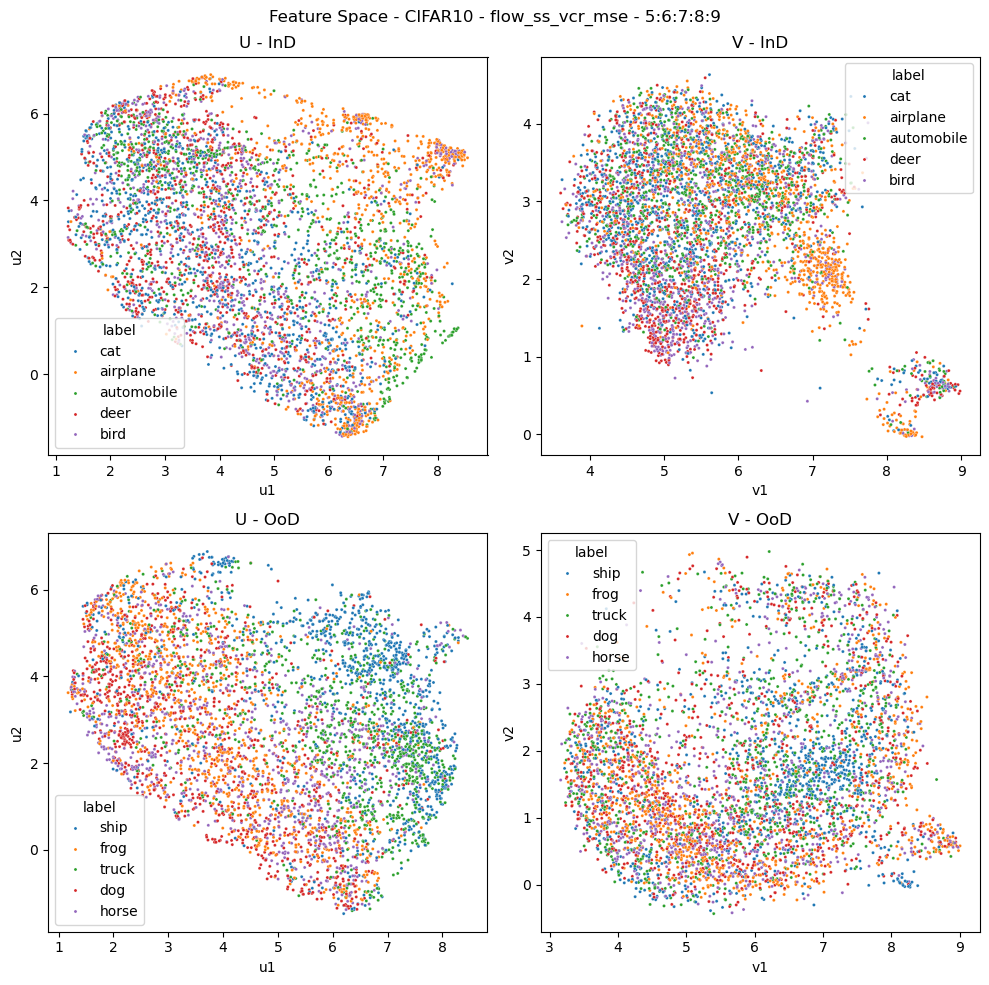

In [12]:
# plot feature space
ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

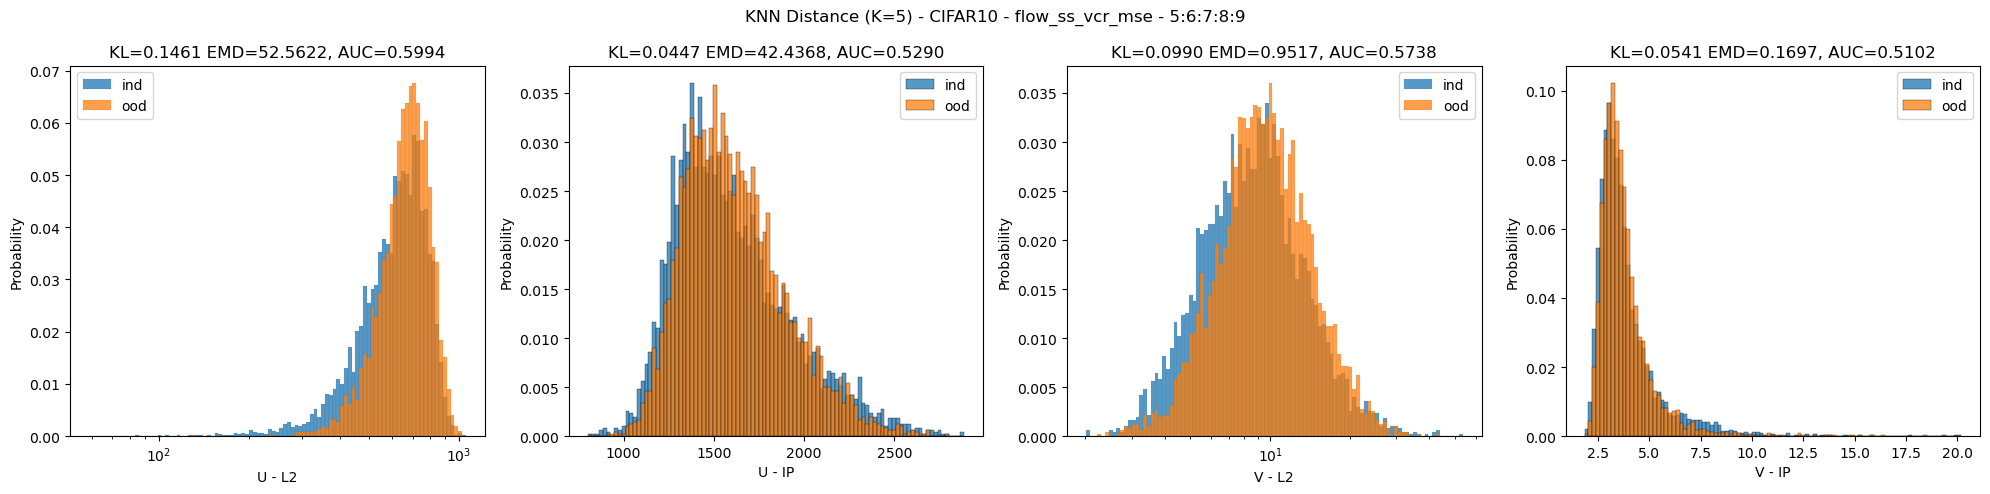

In [13]:
# plot knn distance from ind/ood to val data
def plot_knn_dists(index_fn, ax, trn_data, val_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(trn_data.shape[-1])
    index.add(trn_data)
    Dv = index.search(val_data, k)[0].mean(-1)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=Dv.tolist(), ind_data=Di.tolist(), ood_data=Do.tolist()))
        
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")
run_stats["knn_u_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], trn_e_u, val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="logspace")
axs[0].set_xlabel("U - L2")
run_stats["knn_u_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], trn_e_u, val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="linspace")
axs[1].set_xlabel("U - IP")
run_stats["knn_v_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], trn_e_v, val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="logspace")
axs[2].set_xlabel("V - L2")
run_stats["knn_v_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], trn_e_v, val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="linspace")
axs[3].set_xlabel("V - IP")
plt.tight_layout()
plt.show()

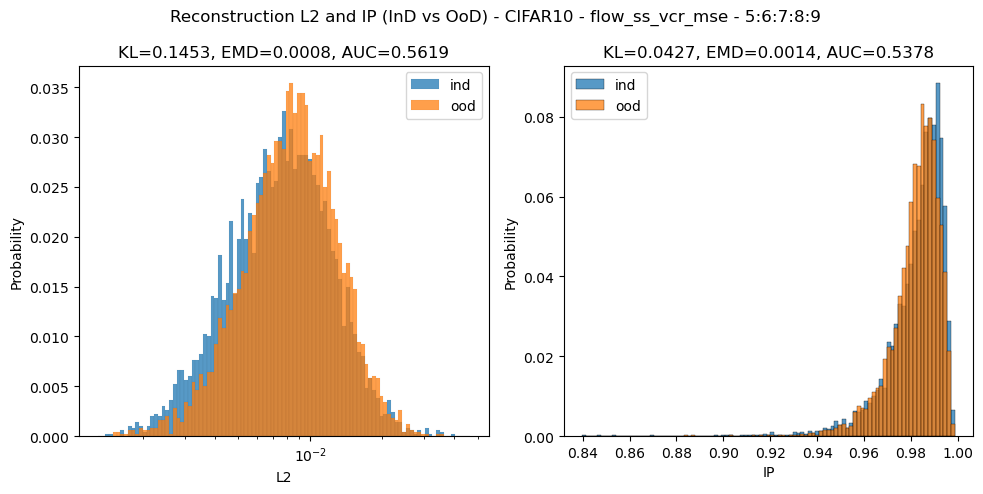

In [14]:
# plot reconstruction-based ood metrics
def plot_rcn(val_rcn, ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=val_rcn.tolist(), ind_data=ind_rcn.tolist(), ood_data=ood_rcn.tolist()))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)


# training data
_val_inp, _val_rcn = flatten(val_inp), flatten(val_rcn)
_val_inp_unit, _val_rcn_unit = unit(_val_inp), unit(_val_rcn)
# metrics
val_rcn_l2 = ((_val_inp - _val_rcn) ** 2).mean(-1)
val_rcn_ip = (_val_inp_unit * _val_rcn_unit).sum(-1)

# ind test data
_ind_inp, _ind_rcn = flatten(ind_inp), flatten(ind_rcn)
_ind_inp_unit, _ind_rcn_unit = unit(_ind_inp), unit(_ind_rcn)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # ood test data
    _ood_inp, _ood_rcn = flatten(ood_inp), flatten(ood_rcn)
    _ood_inp_unit, _ood_rcn_unit = unit(_ood_inp), unit(_ood_rcn)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
run_stats["rcn_l2"] = plot_rcn(val_rcn_l2, ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(val_rcn_ip, ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
# compute vector norms
trn_n_u = np.linalg.norm(trn_e_u, axis=-1)
trn_n_v = np.linalg.norm(trn_e_v, axis=-1)
val_n_u = np.linalg.norm(val_e_u, axis=-1)
val_n_v = np.linalg.norm(val_e_v, axis=-1)
ind_n_u = np.linalg.norm(ind_e_u, axis=-1)
ind_n_v = np.linalg.norm(ind_e_v, axis=-1)

if ood_str:
    ood_n_u = np.linalg.norm(ood_e_u, axis=-1)
    ood_n_v = np.linalg.norm(ood_e_v, axis=-1)

run_stats["norm_u"] = dict(val_data=val_n_u.tolist(), ind_data=ind_n_u.tolist(), ood_data=ood_n_u.tolist() if ood_str else None)
run_stats["norm_v"] = dict(val_data=val_n_v.tolist(), ind_data=ind_n_v.tolist(), ood_data=ood_n_v.tolist() if ood_str else None)

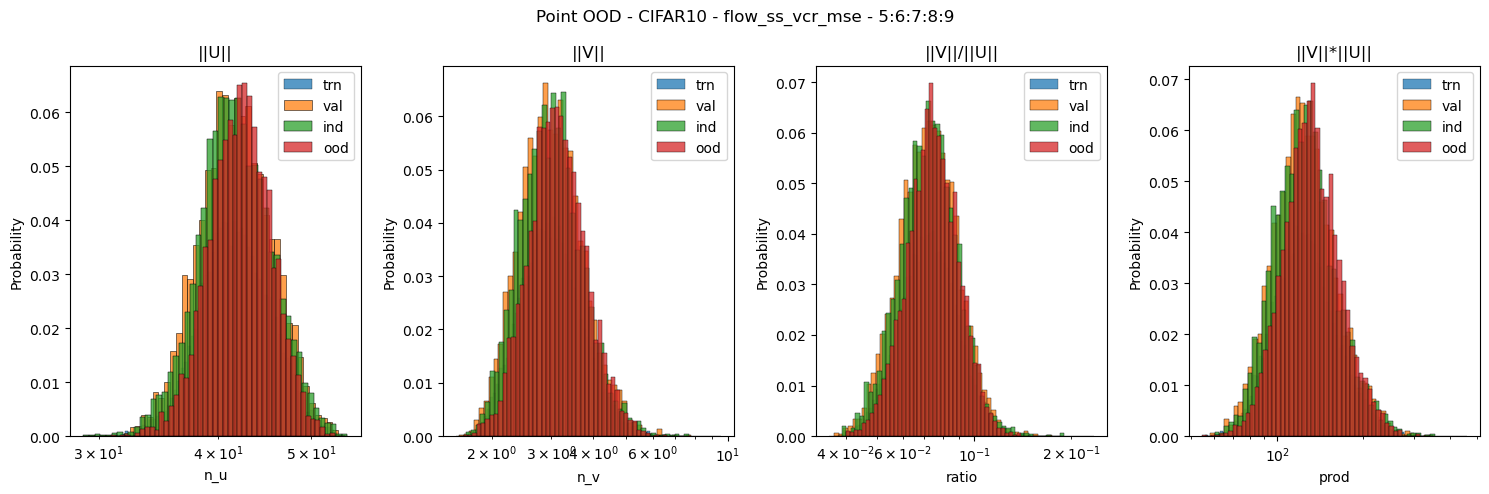

In [16]:
# plot pointwise ood metrics
df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [17]:
# organize data by class, aggregate groupwise
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


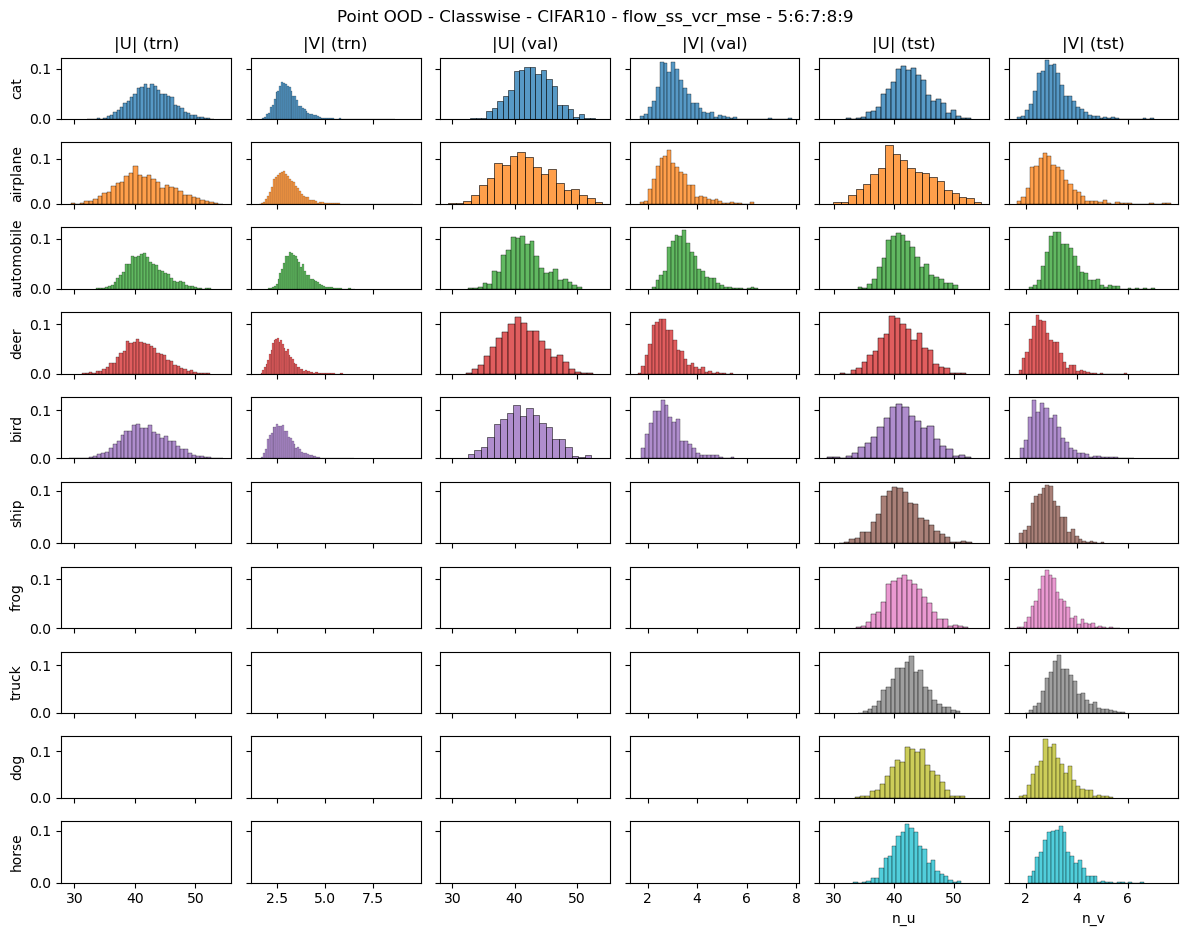

In [18]:
# plot per-class pointwise ood metrics
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

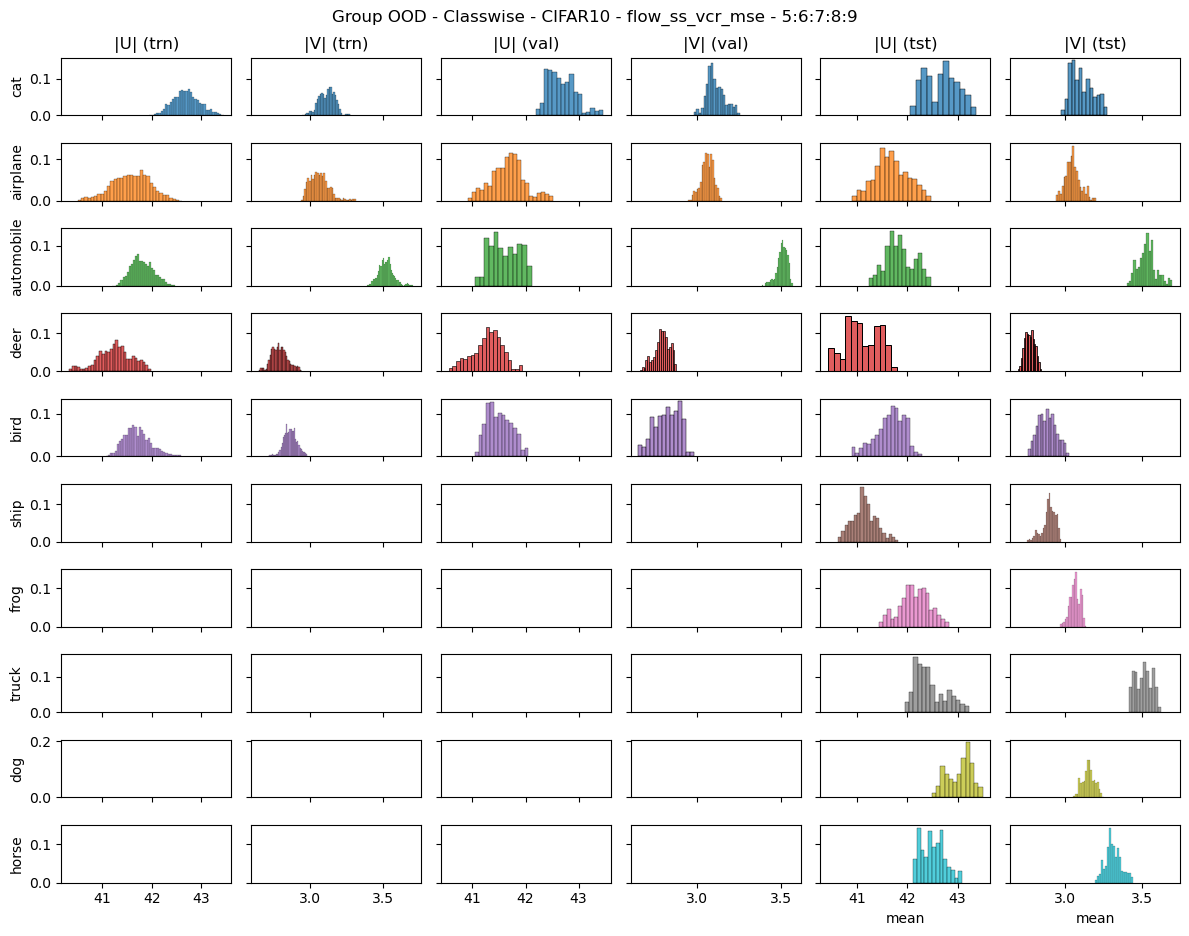

In [19]:
# plot per-class groupwise ood metrics
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

In [20]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))

import json
from datetime import datetime
with open(f"assets/results/{datetime.now()}.json", "w") as f:
    json.dump(run_stats, f)